# CarDD Dataset Data Exploration

This notebook provides a comprehensive exploration of the CarDD (Car Damage Detection) dataset, which contains two main components:

1. **CarDD_COCO**: Object detection format with 6 damage categories
2. **CarDD_SOD**: Salient Object Detection format with images, masks, and edges

## Dataset Overview
- **CarDD_COCO**: Contains annotations in COCO format for object detection tasks
- **CarDD_SOD**: Contains images, masks, and edge maps for salient object detection
- **Damage Categories**: dent, scratch, crack, glass shatter, lamp broken, tire flat


In [1]:
# Import necessary libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Define dataset paths
CARDD_ROOT = "/Users/wjs/Local Storage/CarDD_release"
COCO_PATH = os.path.join(CARDD_ROOT, "CarDD_COCO")
SOD_PATH = os.path.join(CARDD_ROOT, "CarDD_SOD")

print("Dataset paths configured:")
print(f"COCO Path: {COCO_PATH}")
print(f"SOD Path: {SOD_PATH}")
print(f"Paths exist: COCO={os.path.exists(COCO_PATH)}, SOD={os.path.exists(SOD_PATH)}")


Dataset paths configured:
COCO Path: /Users/wjs/Local Storage/CarDD_release/CarDD_COCO
SOD Path: /Users/wjs/Local Storage/CarDD_release/CarDD_SOD
Paths exist: COCO=True, SOD=True


## 1. Dataset Structure Analysis

Let's first examine the overall structure of both datasets to understand what we're working with.


In [2]:
# Function to count files in directory
def count_files(directory, extensions=['.jpg', '.png', '.json']):
    """Count files by extension in a directory"""
    counts = {}
    for ext in extensions:
        count = len([f for f in os.listdir(directory) if f.endswith(ext)]) if os.path.exists(directory) else 0
        counts[ext] = count
    return counts

# Analyze COCO dataset structure
print("=== COCO Dataset Structure ===")
coco_annotations = os.path.join(COCO_PATH, "annotations")
coco_train = os.path.join(COCO_PATH, "train2017")
coco_val = os.path.join(COCO_PATH, "val2017")
coco_test = os.path.join(COCO_PATH, "test2017")

print(f"Annotations: {count_files(coco_annotations)}")
print(f"Train images: {count_files(coco_train)}")
print(f"Val images: {count_files(coco_val)}")
print(f"Test images: {count_files(coco_test)}")

print("\n=== SOD Dataset Structure ===")
sod_train = os.path.join(SOD_PATH, "CarDD-TR")
sod_val = os.path.join(SOD_PATH, "CarDD-VAL")
sod_test = os.path.join(SOD_PATH, "CarDD-TE")

for split in ['TR', 'VAL', 'TE']:
    split_path = os.path.join(SOD_PATH, f"CarDD-{split}")
    if os.path.exists(split_path):
        print(f"\nCarDD-{split}:")
        for subdir in ['Image', 'Mask', 'Edge']:
            subdir_path = os.path.join(split_path, f"CarDD-{split}-{subdir}")
            if os.path.exists(subdir_path):
                count = count_files(subdir_path)
                print(f"  {subdir}: {count}")


=== COCO Dataset Structure ===
Annotations: {'.jpg': 0, '.png': 0, '.json': 3}
Train images: {'.jpg': 2816, '.png': 0, '.json': 0}
Val images: {'.jpg': 810, '.png': 0, '.json': 0}
Test images: {'.jpg': 374, '.png': 0, '.json': 0}

=== SOD Dataset Structure ===

CarDD-TR:
  Image: {'.jpg': 2816, '.png': 0, '.json': 0}
  Mask: {'.jpg': 0, '.png': 2816, '.json': 0}
  Edge: {'.jpg': 0, '.png': 2816, '.json': 0}

CarDD-VAL:
  Image: {'.jpg': 810, '.png': 0, '.json': 0}
  Mask: {'.jpg': 0, '.png': 810, '.json': 0}
  Edge: {'.jpg': 0, '.png': 810, '.json': 0}

CarDD-TE:
  Image: {'.jpg': 374, '.png': 0, '.json': 0}
  Mask: {'.jpg': 0, '.png': 374, '.json': 0}
  Edge: {'.jpg': 0, '.png': 374, '.json': 0}


## 2. COCO Format Analysis

Let's load and analyze the COCO format annotations to understand the damage categories and their distribution.


In [3]:
# Load COCO annotations
def load_coco_annotations(json_path):
    """Load COCO format annotations"""
    with open(json_path, 'r') as f:
        data = json.load(f)
    return data

# Load all COCO annotation files
train_annotations = load_coco_annotations(os.path.join(COCO_PATH, "annotations", "instances_train2017.json"))
val_annotations = load_coco_annotations(os.path.join(COCO_PATH, "annotations", "instances_val2017.json"))
test_annotations = load_coco_annotations(os.path.join(COCO_PATH, "annotations", "instances_test2017.json"))

print("=== COCO Dataset Information ===")
print(f"Train images: {len(train_annotations['images'])}")
print(f"Val images: {len(val_annotations['images'])}")
print(f"Test images: {len(test_annotations['images'])}")

print(f"\nTrain annotations: {len(train_annotations['annotations'])}")
print(f"Val annotations: {len(val_annotations['annotations'])}")
print(f"Test annotations: {len(test_annotations['annotations'])}")

print(f"\nCategories: {len(train_annotations['categories'])}")
for cat in train_annotations['categories']:
    print(f"  {cat['id']}: {cat['name']}")


=== COCO Dataset Information ===
Train images: 2816
Val images: 810
Test images: 374

Train annotations: 6211
Val annotations: 1744
Test annotations: 785

Categories: 6
  1: dent
  2: scratch
  3: crack
  4: glass shatter
  5: lamp broken
  6: tire flat



=== Train Category Distribution ===
scratch: 2560 instances
dent: 1806 instances
crack: 651 instances
lamp broken: 494 instances
glass shatter: 475 instances
tire flat: 225 instances

=== Validation Category Distribution ===
scratch: 728 instances
dent: 501 instances
crack: 177 instances
lamp broken: 141 instances
glass shatter: 135 instances
tire flat: 62 instances

=== Test Category Distribution ===
scratch: 307 instances
dent: 236 instances
glass shatter: 71 instances
crack: 70 instances
lamp broken: 69 instances
tire flat: 32 instances


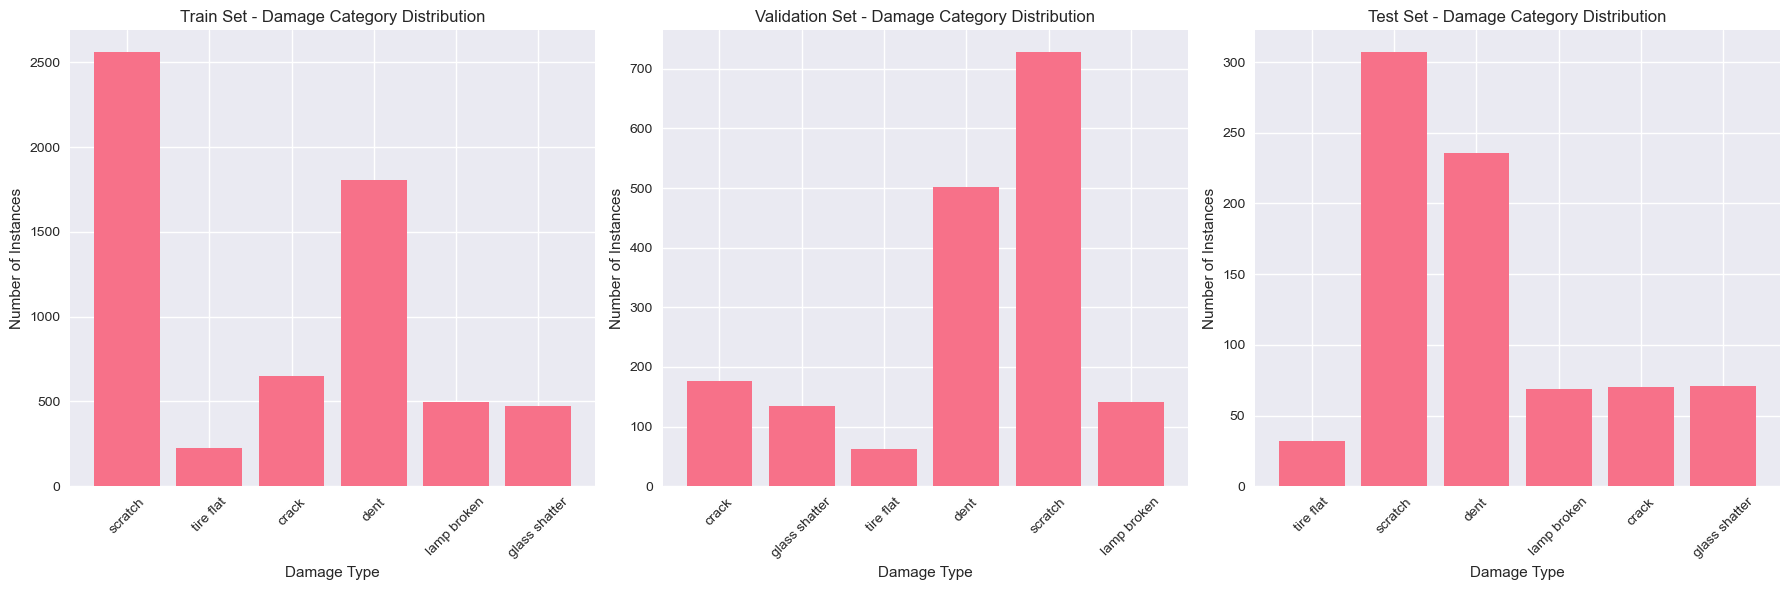

In [4]:
# Analyze damage category distribution
def analyze_category_distribution(annotations, split_name):
    """Analyze the distribution of damage categories"""
    category_counts = Counter([ann['category_id'] for ann in annotations['annotations']])
    category_names = {cat['id']: cat['name'] for cat in annotations['categories']}
    
    print(f"\n=== {split_name} Category Distribution ===")
    for cat_id, count in category_counts.most_common():
        print(f"{category_names[cat_id]}: {count} instances")
    
    return category_counts, category_names

# Analyze all splits
train_cats, train_names = analyze_category_distribution(train_annotations, "Train")
val_cats, val_names = analyze_category_distribution(val_annotations, "Validation")
test_cats, test_names = analyze_category_distribution(test_annotations, "Test")

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

splits = [('Train', train_cats), ('Validation', val_cats), ('Test', test_cats)]
for idx, (split_name, cat_counts) in enumerate(splits):
    categories = [train_names[cat_id] for cat_id in cat_counts.keys()]
    counts = list(cat_counts.values())
    
    axes[idx].bar(categories, counts)
    axes[idx].set_title(f'{split_name} Set - Damage Category Distribution')
    axes[idx].set_xlabel('Damage Type')
    axes[idx].set_ylabel('Number of Instances')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [5]:
# Analyze image dimensions and bounding box statistics
def analyze_image_stats(annotations, split_name):
    """Analyze image dimensions and bounding box statistics"""
    images = annotations['images']
    anns = annotations['annotations']
    
    # Image dimensions
    widths = [img['width'] for img in images]
    heights = [img['height'] for img in images]
    
    # Bounding box statistics
    bbox_areas = []
    bbox_ratios = []
    
    for ann in anns:
        bbox = ann['bbox']  # [x, y, width, height]
        area = bbox[2] * bbox[3]
        ratio = bbox[2] / bbox[3] if bbox[3] > 0 else 0
        bbox_areas.append(area)
        bbox_ratios.append(ratio)
    
    print(f"\n=== {split_name} Image Statistics ===")
    print(f"Image count: {len(images)}")
    print(f"Average width: {np.mean(widths):.1f} ± {np.std(widths):.1f}")
    print(f"Average height: {np.mean(heights):.1f} ± {np.std(heights):.1f}")
    print(f"Average bbox area: {np.mean(bbox_areas):.1f} ± {np.std(bbox_areas):.1f}")
    print(f"Average bbox aspect ratio: {np.mean(bbox_ratios):.2f} ± {np.std(bbox_ratios):.2f}")
    
    return {
        'widths': widths,
        'heights': heights,
        'bbox_areas': bbox_areas,
        'bbox_ratios': bbox_ratios
    }

# Analyze all splits
train_stats = analyze_image_stats(train_annotations, "Train")
val_stats = analyze_image_stats(val_annotations, "Validation")
test_stats = analyze_image_stats(test_annotations, "Test")



=== Train Image Statistics ===
Image count: 2816
Average width: 979.0 ± 77.4
Average height: 705.3 ± 97.2
Average bbox area: 116535.3 ± 150852.5
Average bbox aspect ratio: 1.72 ± 1.55

=== Validation Image Statistics ===
Image count: 810
Average width: 974.9 ± 85.3
Average height: 710.7 ± 100.9
Average bbox area: 118936.3 ± 150971.0
Average bbox aspect ratio: 1.69 ± 1.50

=== Test Image Statistics ===
Image count: 374
Average width: 977.8 ± 82.5
Average height: 702.9 ± 95.8
Average bbox area: 120792.4 ± 150265.5
Average bbox aspect ratio: 1.80 ± 1.71


## 3. SOD Format Analysis

Now let's analyze the Salient Object Detection format data, which includes images, masks, and edge maps.


In [6]:
# Analyze SOD dataset
def analyze_sod_split(split_name):
    """Analyze a SOD dataset split"""
    split_path = os.path.join(SOD_PATH, f"CarDD-{split_name}")
    
    if not os.path.exists(split_path):
        print(f"Split {split_name} not found")
        return None
    
    # Count files in each subdirectory
    image_dir = os.path.join(split_path, f"CarDD-{split_name}-Image")
    mask_dir = os.path.join(split_path, f"CarDD-{split_name}-Mask")
    edge_dir = os.path.join(split_path, f"CarDD-{split_name}-Edge")
    
    image_count = len([f for f in os.listdir(image_dir) if f.endswith('.jpg')]) if os.path.exists(image_dir) else 0
    mask_count = len([f for f in os.listdir(mask_dir) if f.endswith('.png')]) if os.path.exists(mask_dir) else 0
    edge_count = len([f for f in os.listdir(edge_dir) if f.endswith('.png')]) if os.path.exists(edge_dir) else 0
    
    print(f"\n=== SOD {split_name} Split ===")
    print(f"Images: {image_count}")
    print(f"Masks: {mask_count}")
    print(f"Edges: {edge_count}")
    
    return {
        'image_count': image_count,
        'mask_count': mask_count,
        'edge_count': edge_count,
        'image_dir': image_dir,
        'mask_dir': mask_dir,
        'edge_dir': edge_dir
    }

# Analyze all SOD splits
sod_splits = {}
for split in ['TR', 'VAL', 'TE']:
    sod_splits[split] = analyze_sod_split(split)



=== SOD TR Split ===
Images: 2816
Masks: 2816
Edges: 2816

=== SOD VAL Split ===
Images: 810
Masks: 810
Edges: 810

=== SOD TE Split ===
Images: 374
Masks: 374
Edges: 374


## 4. Sample Visualization

Let's visualize some sample images from both COCO and SOD formats to understand the data better.


=== COCO Sample Visualizations ===


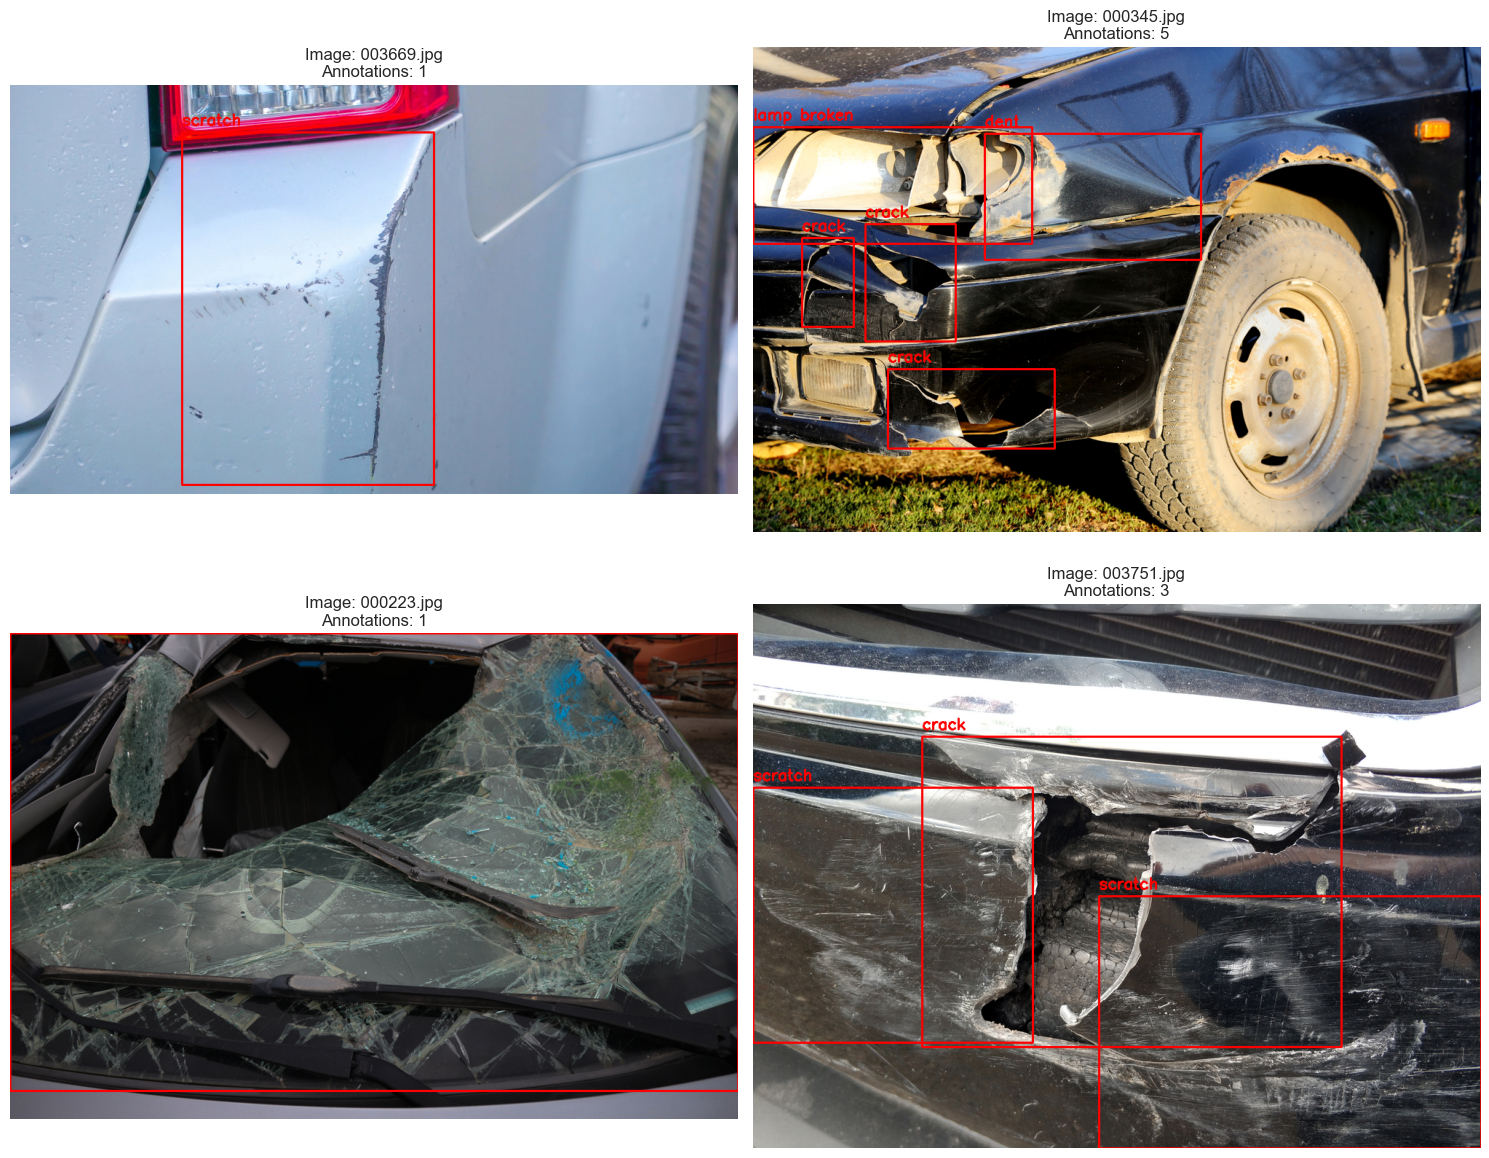

In [7]:
# Function to visualize COCO samples with bounding boxes
def visualize_coco_samples(annotations, image_dir, num_samples=4):
    """Visualize COCO format samples with bounding boxes"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    # Get random sample of images
    sample_images = np.random.choice(annotations['images'], num_samples, replace=False)
    
    for idx, img_info in enumerate(sample_images):
        img_path = os.path.join(image_dir, img_info['file_name'])
        
        if not os.path.exists(img_path):
            continue
            
        # Load image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Get annotations for this image
        img_anns = [ann for ann in annotations['annotations'] if ann['image_id'] == img_info['id']]
        
        # Draw bounding boxes
        for ann in img_anns:
            bbox = ann['bbox']
            x, y, w, h = bbox
            category_name = train_names[ann['category_id']]
            
            # Draw rectangle
            cv2.rectangle(image, (int(x), int(y)), (int(x+w), int(y+h)), (255, 0, 0), 2)
            
            # Add label
            cv2.putText(image, category_name, (int(x), int(y-10)), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        
        axes[idx].imshow(image)
        axes[idx].set_title(f"Image: {img_info['file_name']}\nAnnotations: {len(img_anns)}")
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize COCO samples
print("=== COCO Sample Visualizations ===")
visualize_coco_samples(train_annotations, coco_train)


=== SOD Sample Visualizations ===


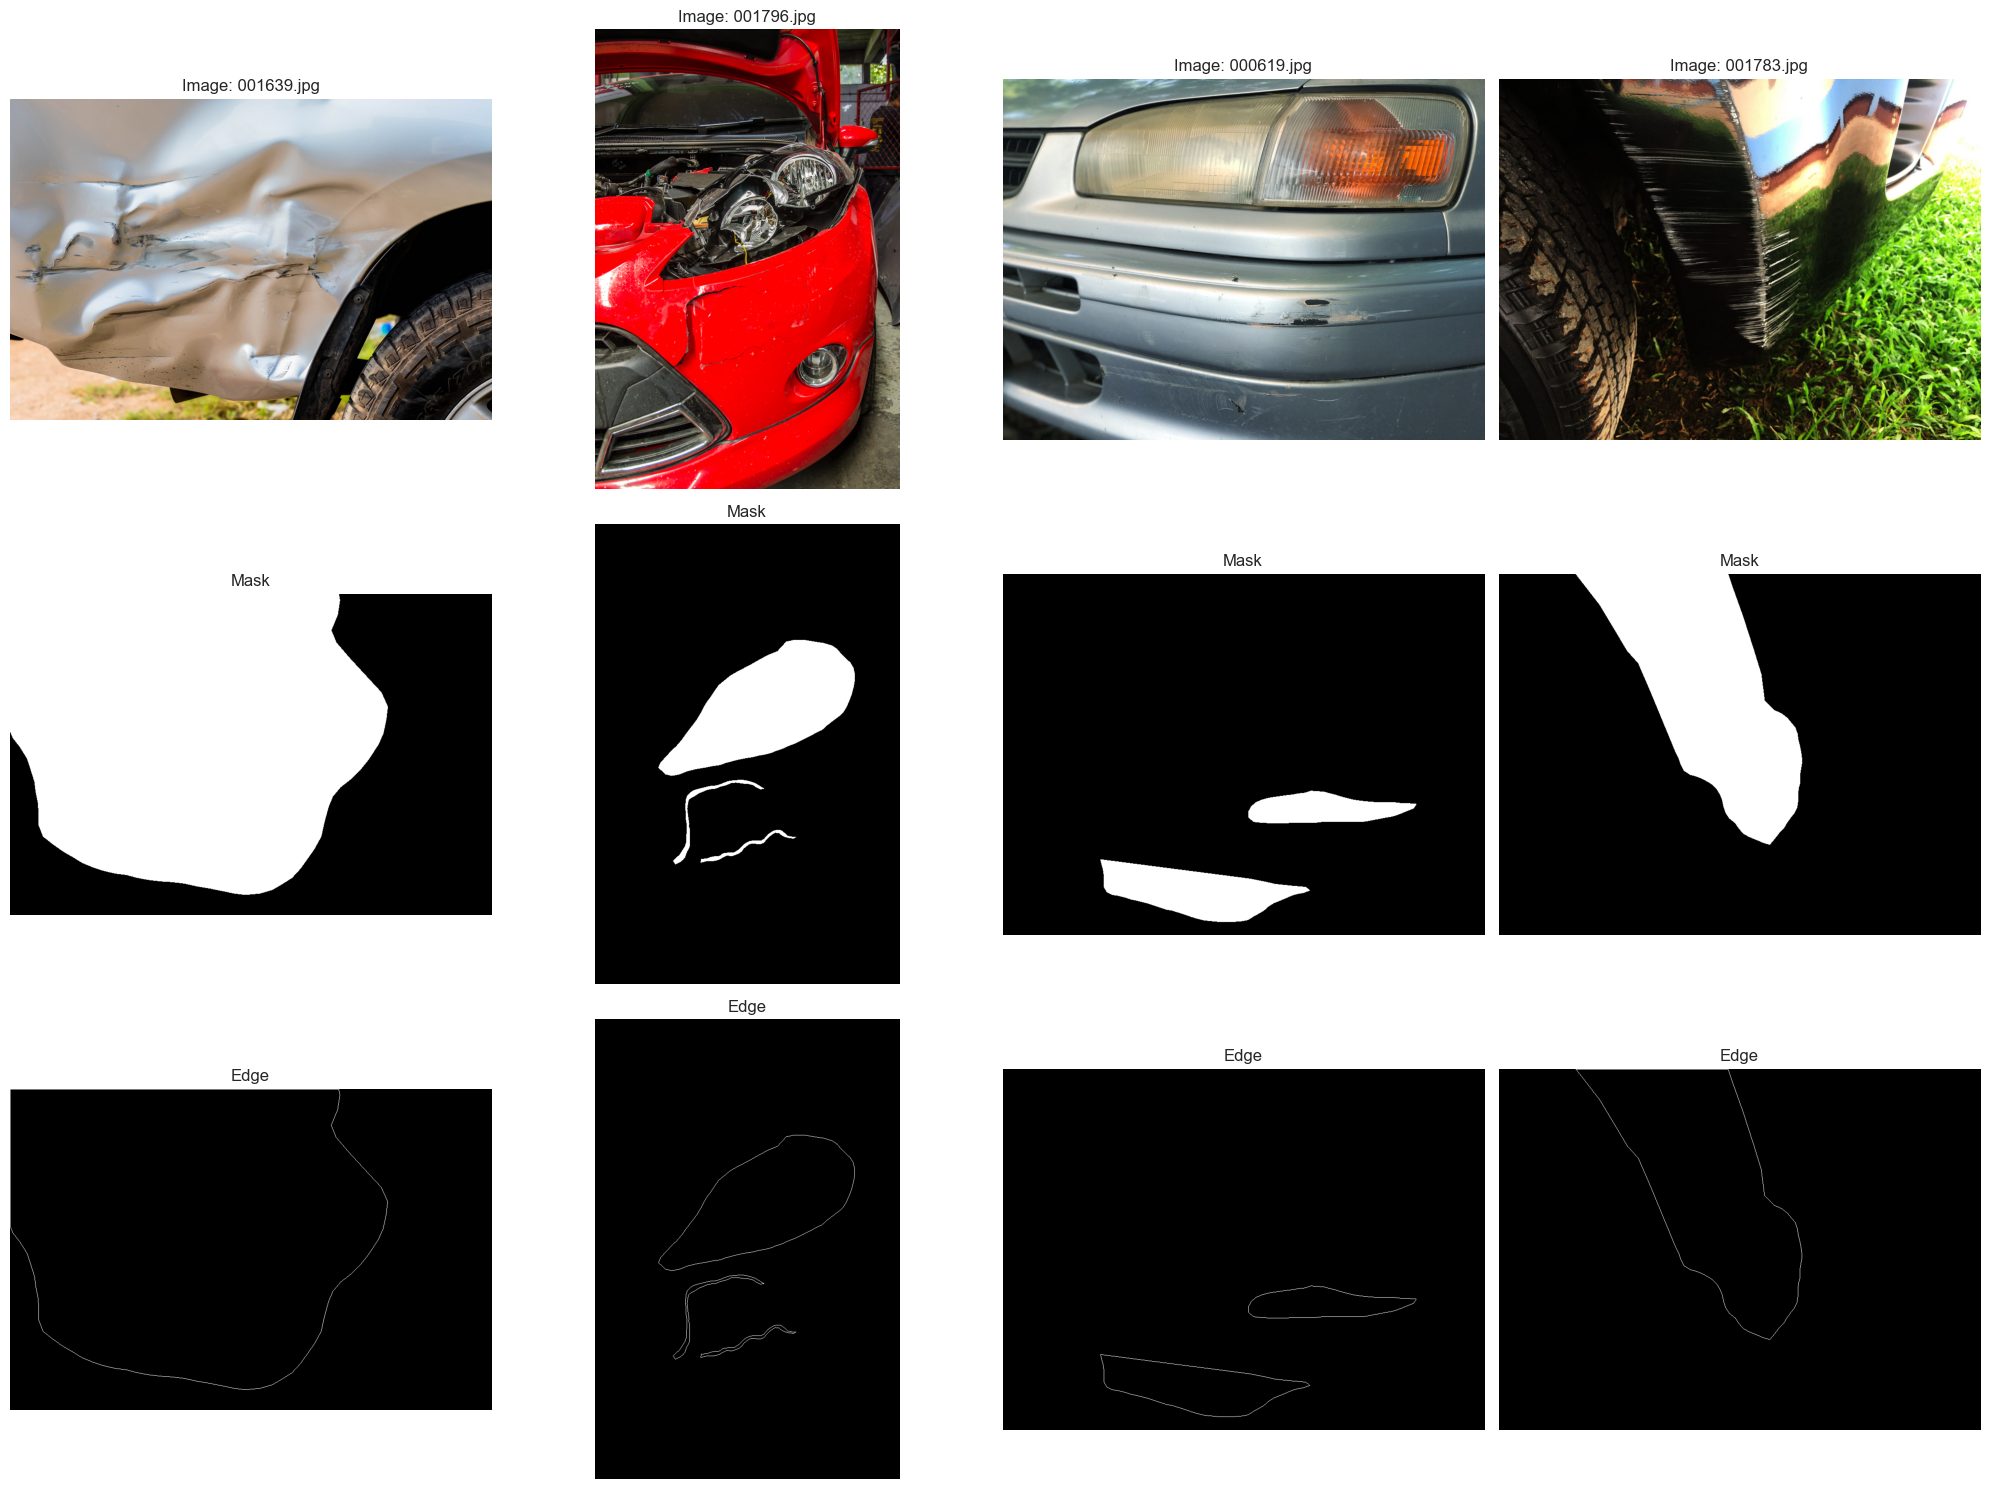

In [8]:
# Function to visualize SOD samples (image, mask, edge)
def visualize_sod_samples(split_info, num_samples=4):
    """Visualize SOD format samples with image, mask, and edge"""
    if not split_info:
        return
        
    fig, axes = plt.subplots(3, num_samples, figsize=(20, 15))
    
    # Get sample image files
    image_files = [f for f in os.listdir(split_info['image_dir']) if f.endswith('.jpg')]
    sample_files = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)
    
    for idx, img_file in enumerate(sample_files):
        # Load image
        img_path = os.path.join(split_info['image_dir'], img_file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load mask
        mask_file = img_file.replace('.jpg', '.png')
        mask_path = os.path.join(split_info['mask_dir'], mask_file)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) if os.path.exists(mask_path) else None
        
        # Load edge
        edge_path = os.path.join(split_info['edge_dir'], mask_file)
        edge = cv2.imread(edge_path, cv2.IMREAD_GRAYSCALE) if os.path.exists(edge_path) else None
        
        # Plot image
        axes[0, idx].imshow(image)
        axes[0, idx].set_title(f"Image: {img_file}")
        axes[0, idx].axis('off')
        
        # Plot mask
        if mask is not None:
            axes[1, idx].imshow(mask, cmap='gray')
            axes[1, idx].set_title("Mask")
        else:
            axes[1, idx].text(0.5, 0.5, 'Mask not found', ha='center', va='center')
        axes[1, idx].axis('off')
        
        # Plot edge
        if edge is not None:
            axes[2, idx].imshow(edge, cmap='gray')
            axes[2, idx].set_title("Edge")
        else:
            axes[2, idx].text(0.5, 0.5, 'Edge not found', ha='center', va='center')
        axes[2, idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize SOD samples
print("=== SOD Sample Visualizations ===")
if sod_splits['TR']:
    visualize_sod_samples(sod_splits['TR'])


## 5. Statistical Analysis and Insights

Let's perform some deeper statistical analysis to understand the dataset characteristics and potential challenges.


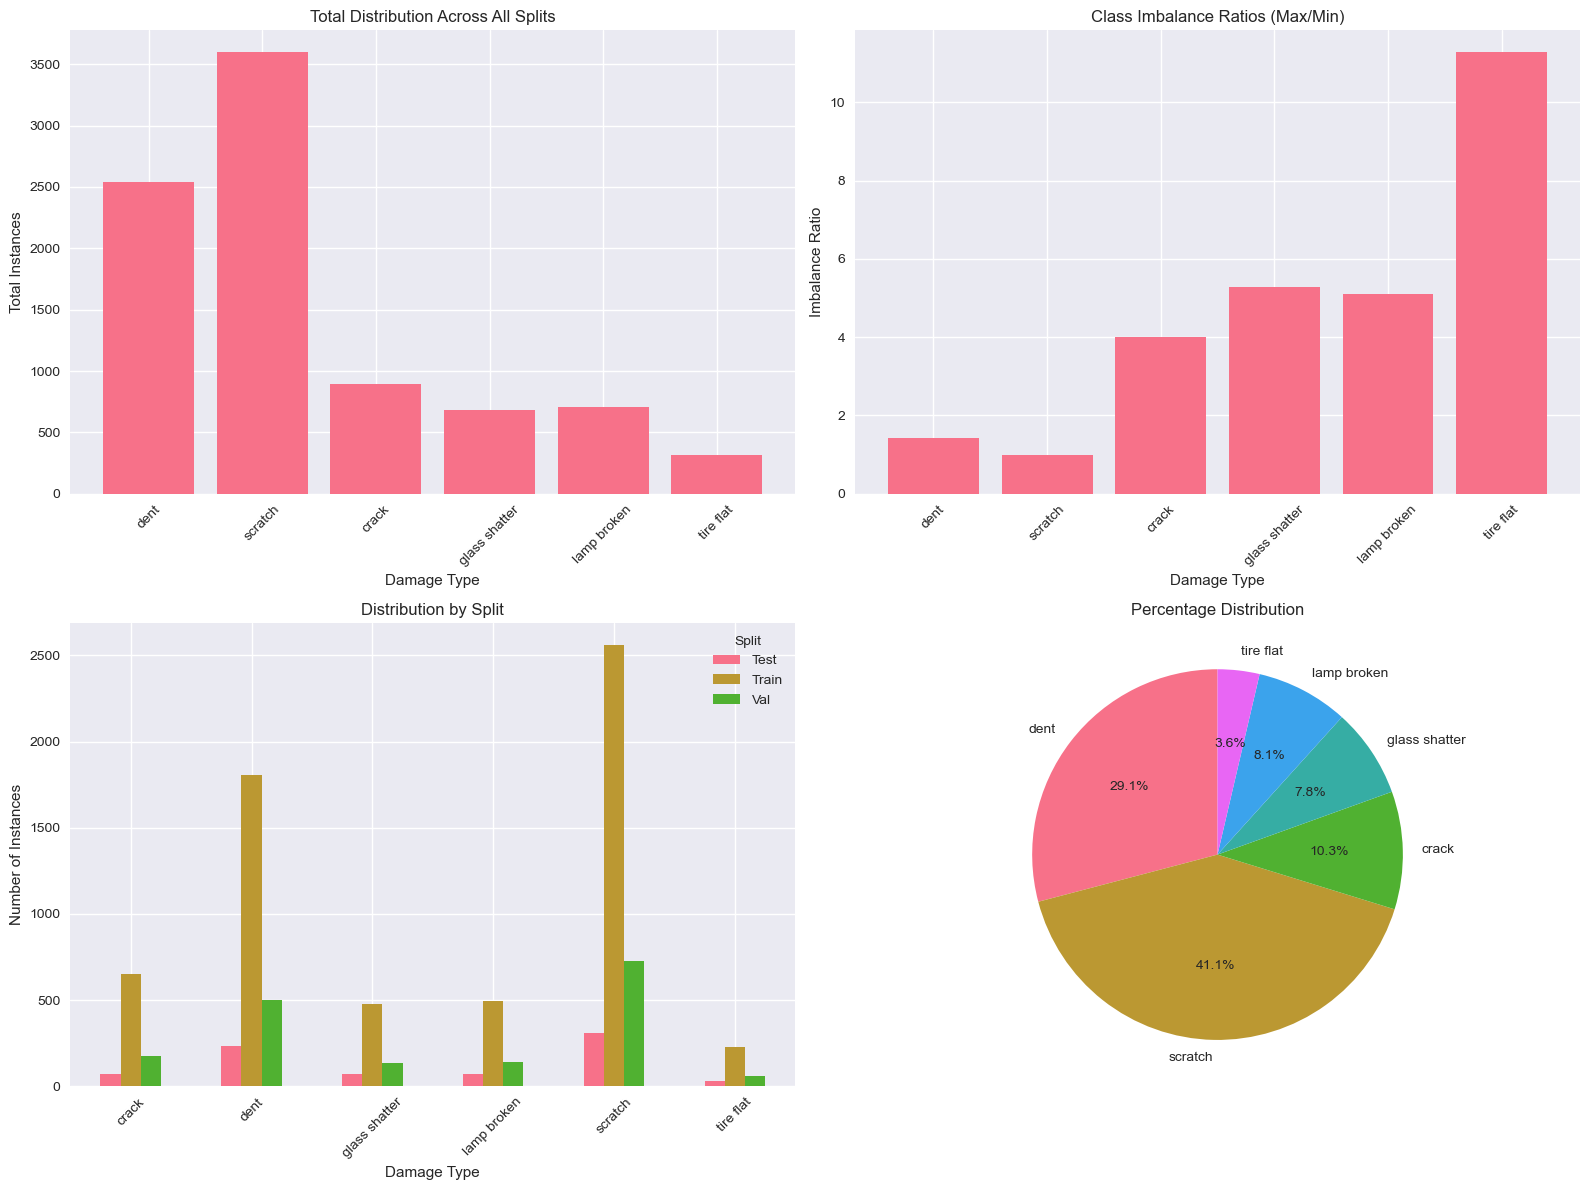

=== Class Imbalance Analysis ===
Most frequent class: scratch (3595 instances)
Least frequent class: tire flat (319 instances)
Imbalance ratio: 11.27:1


In [10]:
# Analyze class imbalance
def analyze_class_imbalance():
    """Analyze class imbalance across all splits"""
    all_categories = train_names
    
    # Create a comprehensive analysis
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Total distribution across all splits
    total_counts = {}
    for cat_id, cat_name in all_categories.items():
        total_counts[cat_name] = (train_cats.get(cat_id, 0) + 
                                 val_cats.get(cat_id, 0) + 
                                 test_cats.get(cat_id, 0))
    
    categories = list(total_counts.keys())
    counts = list(total_counts.values())
    
    axes[0, 0].bar(categories, counts)
    axes[0, 0].set_title('Total Distribution Across All Splits')
    axes[0, 0].set_xlabel('Damage Type')
    axes[0, 0].set_ylabel('Total Instances')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. Class imbalance ratio
    max_count = max(counts)
    imbalance_ratios = [max_count / count for count in counts]
    
    axes[0, 1].bar(categories, imbalance_ratios)
    axes[0, 1].set_title('Class Imbalance Ratios (Max/Min)')
    axes[0, 1].set_xlabel('Damage Type')
    axes[0, 1].set_ylabel('Imbalance Ratio')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 3. Distribution by split
    split_data = []
    for split_name, split_cats in [('Train', train_cats), ('Val', val_cats), ('Test', test_cats)]:
        for cat_id, cat_name in all_categories.items():
            split_data.append({
                'Split': split_name,
                'Category': cat_name,
                'Count': split_cats.get(cat_id, 0)
            })
    
    split_df = pd.DataFrame(split_data)
    split_pivot = split_df.pivot(index='Category', columns='Split', values='Count')
    
    split_pivot.plot(kind='bar', ax=axes[1, 0])
    axes[1, 0].set_title('Distribution by Split')
    axes[1, 0].set_xlabel('Damage Type')
    axes[1, 0].set_ylabel('Number of Instances')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].legend(title='Split')
    
    # 4. Percentage distribution
    percentages = [count / sum(counts) * 100 for count in counts]
    axes[1, 1].pie(percentages, labels=categories, autopct='%1.1f%%', startangle=90)
    axes[1, 1].set_title('Percentage Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Print imbalance statistics
    print("=== Class Imbalance Analysis ===")
    print(f"Most frequent class: {max(total_counts, key=total_counts.get)} ({max(total_counts.values())} instances)")
    print(f"Least frequent class: {min(total_counts, key=total_counts.get)} ({min(total_counts.values())} instances)")
    print(f"Imbalance ratio: {max(total_counts.values()) / min(total_counts.values()):.2f}:1")
    
    return total_counts

# Run class imbalance analysis
total_counts = analyze_class_imbalance()


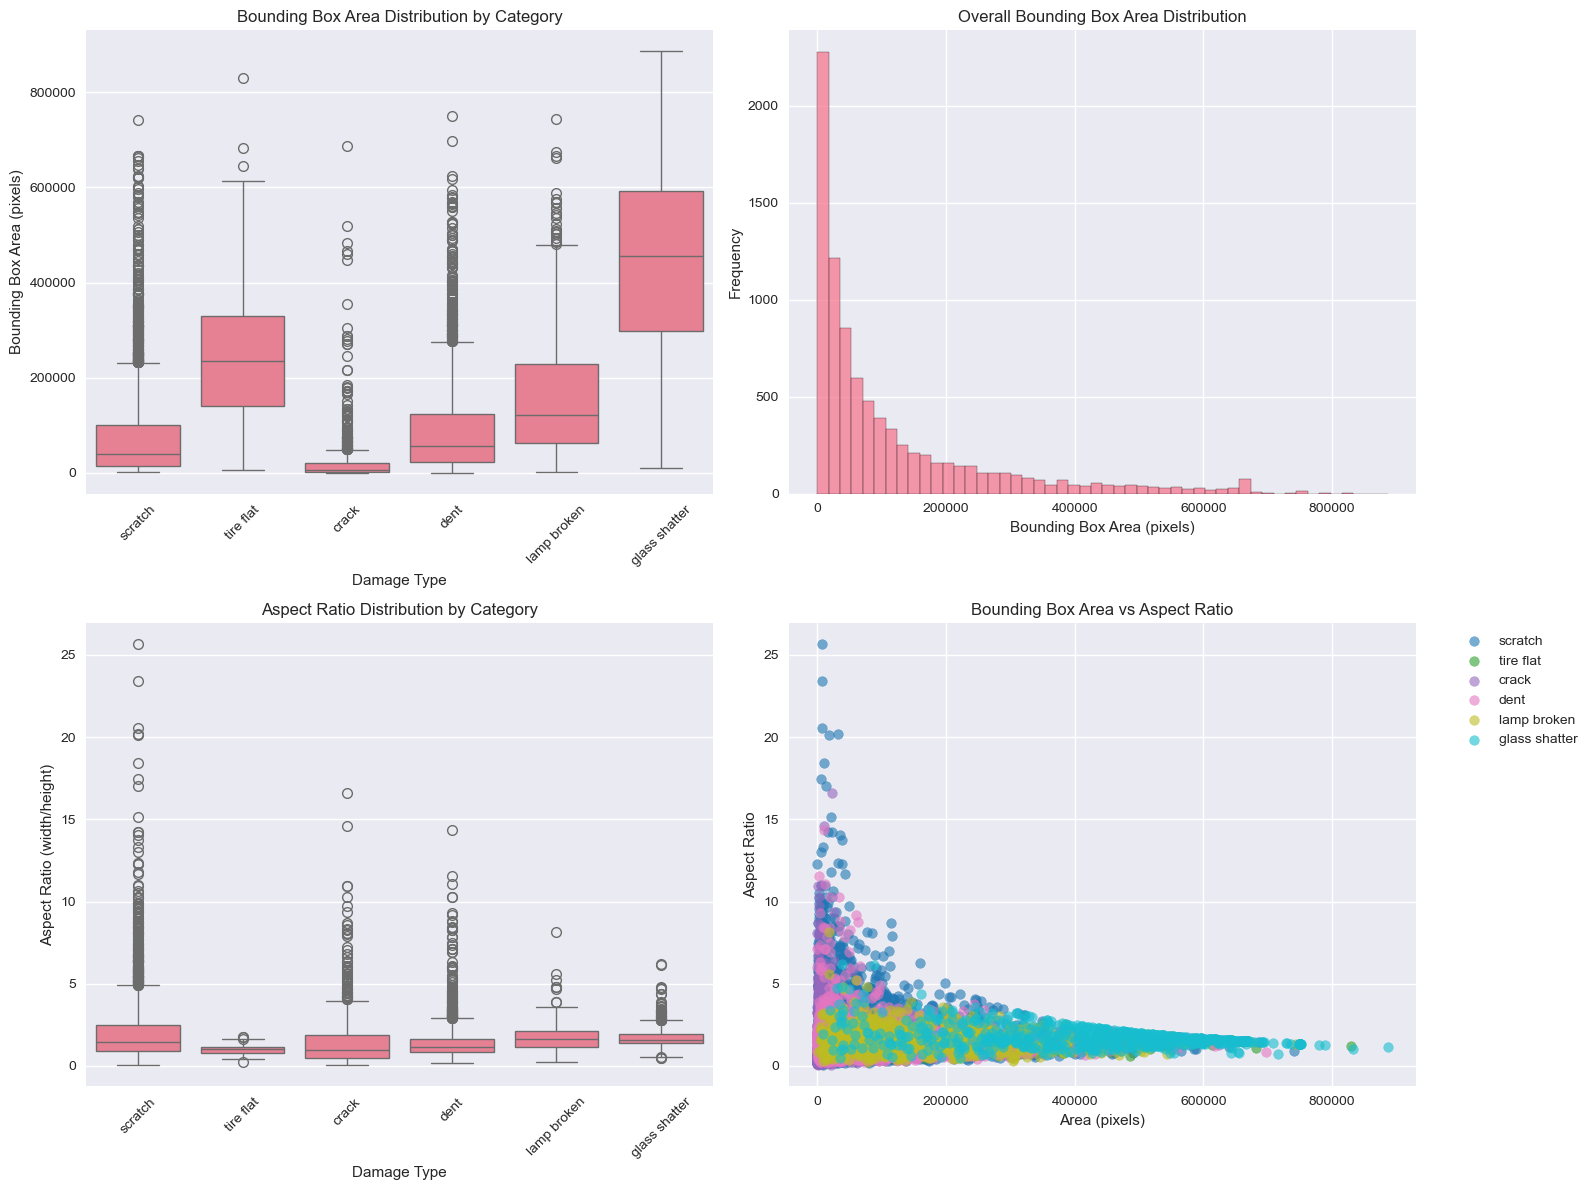

=== Bounding Box Statistics ===
Total bounding boxes: 8740
Average area: 117396.8 ± 150830.3
Average aspect ratio: 1.72 ± 1.55

scratch:
  Count: 3595
  Avg area: 78280.2 ± 101166.0
  Avg ratio: 2.06 ± 1.98

tire flat:
  Count: 319
  Avg area: 243473.9 ± 134476.0
  Avg ratio: 1.00 ± 0.24

crack:
  Count: 898
  Avg area: 24112.3 ± 56783.3
  Avg ratio: 1.50 ± 1.66

dent:
  Count: 2543
  Avg area: 92446.7 ± 102162.9
  Avg ratio: 1.42 ± 1.07

lamp broken:
  Count: 704
  Avg area: 160099.8 ± 130631.9
  Avg ratio: 1.69 ± 0.80

glass shatter:
  Count: 681
  Avg area: 436868.2 ± 187976.4
  Avg ratio: 1.74 ± 0.65


In [11]:
# Analyze bounding box size distribution
def analyze_bbox_distribution():
    """Analyze bounding box size distribution across damage types"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Combine all annotations
    all_annotations = (train_annotations['annotations'] + 
                      val_annotations['annotations'] + 
                      test_annotations['annotations'])
    
    # Group by category
    category_bboxes = {}
    for ann in all_annotations:
        cat_id = ann['category_id']
        cat_name = train_names[cat_id]
        bbox = ann['bbox']
        area = bbox[2] * bbox[3]
        ratio = bbox[2] / bbox[3] if bbox[3] > 0 else 0
        
        if cat_name not in category_bboxes:
            category_bboxes[cat_name] = {'areas': [], 'ratios': []}
        
        category_bboxes[cat_name]['areas'].append(area)
        category_bboxes[cat_name]['ratios'].append(ratio)
    
    # Plot area distribution
    areas_data = []
    labels_data = []
    for cat_name, data in category_bboxes.items():
        areas_data.extend(data['areas'])
        labels_data.extend([cat_name] * len(data['areas']))
    
    area_df = pd.DataFrame({'Area': areas_data, 'Category': labels_data})
    
    # Box plot of areas
    sns.boxplot(data=area_df, x='Category', y='Area', ax=axes[0, 0])
    axes[0, 0].set_title('Bounding Box Area Distribution by Category')
    axes[0, 0].set_xlabel('Damage Type')
    axes[0, 0].set_ylabel('Bounding Box Area (pixels)')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Histogram of areas
    axes[0, 1].hist(areas_data, bins=50, alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('Overall Bounding Box Area Distribution')
    axes[0, 1].set_xlabel('Bounding Box Area (pixels)')
    axes[0, 1].set_ylabel('Frequency')
    
    # Aspect ratio analysis
    ratios_data = []
    labels_ratios = []
    for cat_name, data in category_bboxes.items():
        ratios_data.extend(data['ratios'])
        labels_ratios.extend([cat_name] * len(data['ratios']))
    
    ratio_df = pd.DataFrame({'Ratio': ratios_data, 'Category': labels_ratios})
    
    # Box plot of aspect ratios
    sns.boxplot(data=ratio_df, x='Category', y='Ratio', ax=axes[1, 0])
    axes[1, 0].set_title('Aspect Ratio Distribution by Category')
    axes[1, 0].set_xlabel('Damage Type')
    axes[1, 0].set_ylabel('Aspect Ratio (width/height)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Scatter plot: area vs aspect ratio
    colors = plt.cm.tab10(np.linspace(0, 1, len(category_bboxes)))
    for i, (cat_name, data) in enumerate(category_bboxes.items()):
        axes[1, 1].scatter(data['areas'], data['ratios'], 
                          alpha=0.6, label=cat_name, color=colors[i])
    
    axes[1, 1].set_title('Bounding Box Area vs Aspect Ratio')
    axes[1, 1].set_xlabel('Area (pixels)')
    axes[1, 1].set_ylabel('Aspect Ratio')
    axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("=== Bounding Box Statistics ===")
    print(f"Total bounding boxes: {len(all_annotations)}")
    print(f"Average area: {np.mean(areas_data):.1f} ± {np.std(areas_data):.1f}")
    print(f"Average aspect ratio: {np.mean(ratios_data):.2f} ± {np.std(ratios_data):.2f}")
    
    for cat_name, data in category_bboxes.items():
        print(f"\n{cat_name}:")
        print(f"  Count: {len(data['areas'])}")
        print(f"  Avg area: {np.mean(data['areas']):.1f} ± {np.std(data['areas']):.1f}")
        print(f"  Avg ratio: {np.mean(data['ratios']):.2f} ± {np.std(data['ratios']):.2f}")

# Run bounding box analysis
analyze_bbox_distribution()


In [ ]:
import numpy as np
from PIL import Image
from manipulation_tools import InpainterTool
import os

os.makedirs("./api_debug", exist_ok=True)

# Create a random RGB image (256x256) and a full white mask
img = (np.random.rand(256, 256, 3) * 255).astype('uint8')
mask = np.ones((256, 256), dtype='uint8') * 0

img_path = "./api_debug/test_image.png"
mask_path = "./api_debug/test_mask.png"
Image.fromarray(img).save(img_path)
Image.fromarray(mask).save(mask_path)

tool = InpainterTool(use_local=True, output_dir="./api_debug")
out = tool.process_image(
    img_path,
    mask_path,
    prompt="a photorealistic cat, high detail, sharp, natural lighting"
)
print("Result path:", out)

Using local API fallback with model: local-fallback v1.0.0 (local)
📤 Sending request to local API with prompt: a photorealistic cat, high detail, sharp, natural lighting
✅ Local API: Successfully inpainted api_debug_test_image.png
   Result saved to: ./api_debug/inpainted_1757412720571_8144.png
Result path: ./api_debug/inpainted_1757412720571_8144.png


In [ ]:
#